In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import classification_report

## *Objetivo: El problema propuesto consiste en predecir la categoría a la que pertenece un anunció a partir de su título*

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('x_test.csv')

In [6]:
df_train.shape

(107191, 2)

In [7]:
df_test.head()

,Id,title,Predicted
0,0,Collar Marga Black,NaN
1,1,Microfono Condenser Rode Nt5,NaN
2,2,Apple Watch + Nike 42mm Silver Aluminum Case P...,NaN
3,3,Casco Abierto Shiro Sh-62 Monocolor Gris - Um,NaN
4,4,Jeans Negro Roto Chupin Hombre Ybr Jeans,NaN


In [8]:
gr = df_train.groupby(['category']).size().reset_index(name='counts')
#gr

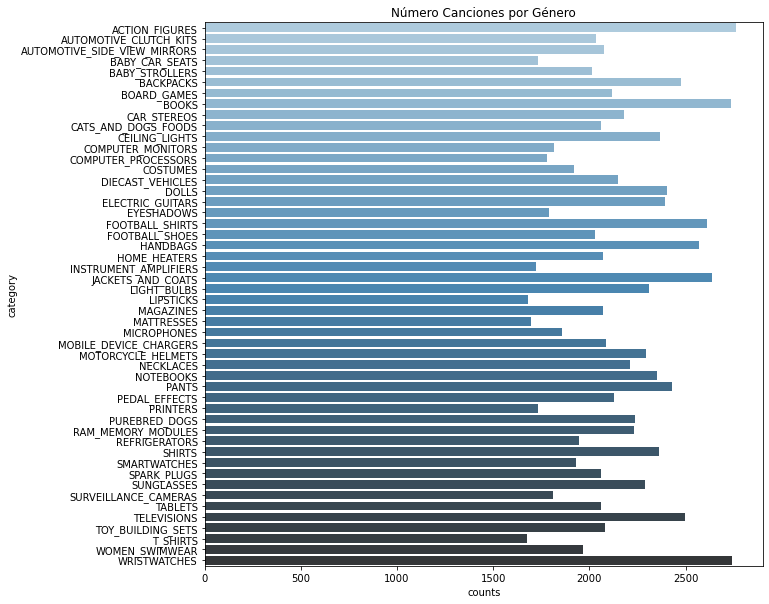

In [9]:
fig, ax = plt.subplots(figsize=(10,10),nrows=1)
sns.barplot(data=gr, y='category', x='counts', palette="Blues_d",ax=ax)
ax.set_title('Número Canciones por Género')
plt.show()

# Procesamiento de datos

## Encoding de las clases usando `LabelBinarizer`

In [10]:
from sklearn.preprocessing import LabelBinarizer

In [11]:
#lb = LabelBinarizer()

In [12]:
#Y = lb.fit_transform(df_train.category)

In [13]:
#Y.shape

In [14]:
Y = df_train.category

## Pre-procesamiento de texto

In [17]:
!pip install nltk

Processing ./.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155/nltk-3.5-py3-none-any.whl
  Using cached regex-2020.10.23-cp38-cp38-manylinux2010_x86_64.whl (675 kB)


In [18]:
import nltk

In [19]:
#nltk.download('all-corpora')
#nltk.download('all')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TfidfVectorizer().build_tokenizer()

In [21]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [22]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [23]:
##stop-words: el vectorizador ya las remueve pero para mostrar las palabras más frecuente tiene sentido activarlo
remove_stops_here = True

def my_pre_processer(text):
    results = []
    for token in tokenizer(text):
        clean_token = token.lower().strip().strip('-').strip('_')
        if remove_stops_here and (clean_token in stopwords.words('spanish')):
          continue
        #token_pro = stemmer.stem(clean_token) #podemos probar stemming en vez de lematizacion
        token_pro = lemmatizer.lemmatize(clean_token) 
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

In [24]:
print(df_train.title.values[1])
print(my_pre_processer(df_train.title.values[1]))

Kit 4 Bujias Ngk Ford F-100 3.0 Bp5efs
['kit', 'bujias', 'ngk', 'ford', 'bp5efs']


In [25]:
#df_train['prep_title'] = df_train['title'].apply(my_pre_processer)

In [26]:
#print(df_train['prep_title'])
#print("\n")

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer


ngram_max = 1
max_features = 10000
max_df=0.8
min_df=1

#vectorizer = TfidfVectorizer(stop_words=None,tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))
#vectorizer = CountVectorizer(stop_words='english',tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,
#                              binary=True, ngram_range=(1, ngram_max))
vectorizer = TfidfVectorizer(stop_words='english',tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,
                              binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))

#vectorizer = TfidfVectorizer(encoding='latin-1',max_df=0.90, min_df=5, max_features=9000)

In [28]:
%%time
vectorizer.fit(df_train.title)
vector_titles = vectorizer.transform(df_train.title)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 4min 18s, sys: 17.3 s, total: 4min 35s
Wall time: 4min 36s


In [29]:
X = vector_titles

In [30]:
X[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

## El SMOTE

In [33]:
!pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.7.0-py3-none-any.whl (167 kB)


In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
oversample = SMOTE(random_state=42)

In [36]:
#%%time
X,Y = oversample.fit_resample(X, Y)

## Splits datasets

In [37]:
#from sklearn.model_selection import train_test_split

In [38]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [39]:
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
#print(X_val.shape, y_val.shape)

## El multinomial que le dicen po

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
clf = LogisticRegression(max_iter=1000)

In [42]:
%%time
#clf.fit(X_train, y_train)
clf.fit(X,Y)

CPU times: user 1min 4s, sys: 10.9 s, total: 1min 15s
Wall time: 1min 15s


LogisticRegression(max_iter=1000)

In [43]:
#s_train = clf.score(X, y)
#s_test = clf.score(X_test, y_test)
#print(s_train, s_test)

## Prediccion pulenta

In [44]:
%%time
vector_titles_submission = vectorizer.transform(df_test.title)

CPU times: user 1min 24s, sys: 5.39 s, total: 1min 29s
Wall time: 1min 29s


In [45]:
vector_titles_submission.shape

(71461, 10000)

In [46]:
vector_titles_submission[0]

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [47]:
y_pred_submission = clf.predict(vector_titles_submission)

In [48]:
y_pred_submission.shape

(71461,)

In [49]:
#df_test.Predicted = lb.inverse_transform(y_pred_submission)
df_test.Predicted = y_pred_submission

In [50]:
df_test.head(50)

,Id,title,Predicted
0,0,Collar Marga Black,NECKLACES
1,1,Microfono Condenser Rode Nt5,MICROPHONES
2,2,Apple Watch + Nike 42mm Silver Aluminum Case P...,SMARTWATCHES
3,3,Casco Abierto Shiro Sh-62 Monocolor Gris - Um,MOTORCYCLE_HELMETS
4,4,Jeans Negro Roto Chupin Hombre Ybr Jeans,PANTS
5,5,Monitor Samsung 28 4k U28e590d Uhd 3840x2160 F...,COMPUTER_MONITORS
6,6,Cargador + Usb + Auriculares Ultima Unidad En ...,MOBILE_DEVICE_CHARGERS
7,7,Cargador De Pared 2a Con Doble Usb,MOBILE_DEVICE_CHARGERS
8,8,Impresora Laser Canon 6030w Wifi Reemp Hp 1102...,PRINTERS
9,9,Remeras Personalizadas Sublimadas O Esyampadas,T_SHIRTS


### save submission

In [51]:
df_submission = pd.read_csv('sample_submission.csv')

In [52]:
df_submission.head()

,Id,Predicted
0,0,PANTS
1,1,SPARK_PLUGS
2,2,FOOTBALL_SHOES
3,3,AUTOMOTIVE_CLUTCH_KITS
4,4,CAR_STEREOS


In [53]:
df_submission.Predicted = df_test.Predicted

In [54]:
df_submission.head()

,Id,Predicted
0,0,NECKLACES
1,1,MICROPHONES
2,2,SMARTWATCHES
3,3,MOTORCYCLE_HELMETS
4,4,PANTS


In [55]:
df_submission.to_csv('last1_submission.csv', index=False, header=True)